In [1]:
import os
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

from utils import  plot_orientations
import r2star
from trabonesim import TraBoneSim

In [5]:
inputdir = os.path.abspath('../data/')

T = TraBoneSim(bonecube_id='P8',
                inputdir=inputdir)

In [6]:
T.set_bone_mask()


bonecube_id = P8
inputdir = /Users/sophiakronthaler/LRZ Sync+Share/trabecular_bone_sim/data
binary_erosion = 0
binary_erosion_se = None

Load Data. Done.


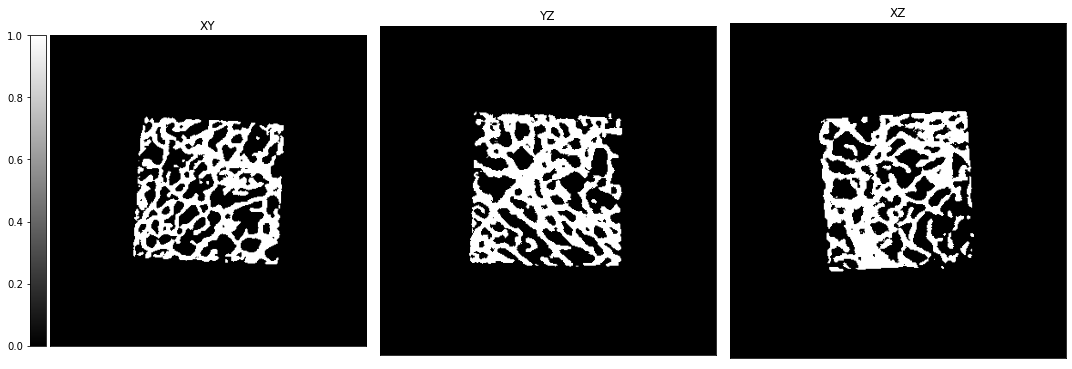

In [7]:
# plot the trabecular bone cube in all three planes
f = plot_orientations(T.mask, cmap='gray')

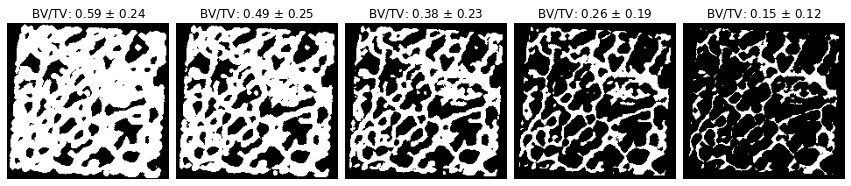

In [8]:
# plot different bone densities

mask = T.mask[T.bbox]
erosion_mask = np.array([[[0, 0, 0], [0, 1, 0], [0, 0, 0]],
                               [[0, 1, 0], [1, 1, 1], [0, 1, 0]],
                               [[0, 0, 0], [0, 1, 0], [0, 0, 0]]])

fig = plt.figure(figsize=(15,6))
grid = AxesGrid(fig, 111, nrows_ncols=(1, 5), axes_pad=0.1)

[g.set_axis_off() for g in grid ]

for i, m in enumerate([
            ndi.binary_dilation(mask, iterations=2, structure=erosion_mask),
            ndi.binary_dilation(mask, iterations=1, structure=erosion_mask),
            mask,
            ndi.binary_erosion(mask, iterations=1, structure=erosion_mask),
            ndi.binary_erosion(mask, iterations=2, structure=erosion_mask)]):

    grid[i].imshow(m[:,:,mask.shape[2] // 2], vmin=0, vmax=1, cmap='gray')
    grid[i].set_title(r'BV/TV: {0:.2f} $\pm$ {1:.2f}'.format(m.mean(), m.var()))

In [9]:
T.te_s = np.array([0e-3, 0.6e-3, 2e-3, 10e-3])
T.simulate_rdf_ppm()
T.simulate_signal()

Forward simulate RDF. Done.
Generate microscopic signal. Done.


Text(0.5, 1.0, '[ppm]')

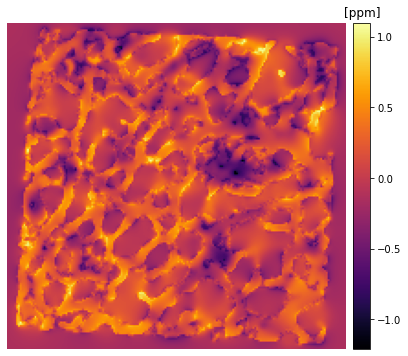

In [10]:
# plot RDF
iz = T.rdf_ppm.shape[2] // 2

fig, ax = plt.subplots(figsize=(15, 6))
im = ax.imshow(T.rdf_ppm[T.bbox[0],T.bbox[1], iz], cmap='inferno')
ax.set_axis_off()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_title('[ppm]')

(-1.5, 1.0)

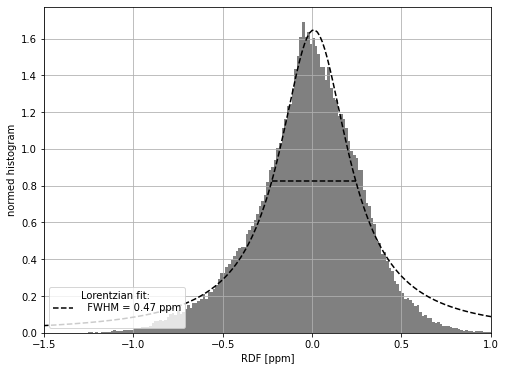

In [11]:
# plot distribution within MR voxel

fig, ax = plt.subplots(figsize=(8, 6))

x = np.ndarray.flatten(T.rdf_ppm[100:180, 140:180, 140:180])
hist = ax.hist(x, density=True, bins='auto', color='gray')
xdata = hist[1][1:]
ydata = hist[0]

I, g, x0, pcov = r2star.fit_Lorentzian(xdata, ydata)
ax.plot(xdata, r2star.Lorentzian(xdata, I, g, x0), '--k',
        label='Lorentzian fit: \n  FWHM = {0:.2f} ppm\n'.format(2*g))
ax.plot([x0-g, x0+g], [I/2, I/2], '--', c='k')
ax.set_xlabel('RDF [ppm]')
ax.set_ylabel('normed histogram')
ax.legend(loc='lower left')
ax.grid()
ax.set_xlim(-1.5, 1)

Text(0.5, 1.0, '[rad]')

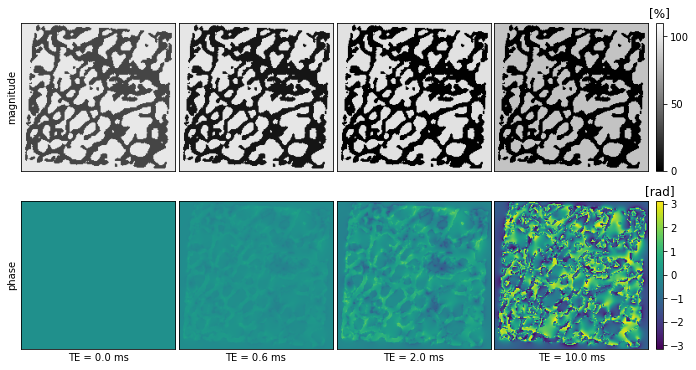

In [14]:
bbox = tuple([slice(80,280), slice(80,280), slice(80,280)])
s_ = T.smicro

fig = plt.figure(figsize=(15, 6))

#### first row - magnitude
grid = AxesGrid(fig, 211,
                nrows_ncols=(1, T.te_s.size),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

iz = s_.shape[2] // 2
grid[0].set_ylabel('magnitude')
for i, te in enumerate(T.te_s):
    im = grid[i].imshow(np.abs(s_[:, :, iz, i]*100), vmin=0, vmax=110, cmap='gray')
    grid[i].xaxis.set_ticks([])
    grid[i].yaxis.set_ticks([])

cbar = grid.cbar_axes[0].colorbar(im)
cbar.ax.set_title('[%]')
cbar.set_ticks([0, 50, 100])

#### second row - phase
grid = AxesGrid(fig, 212,
                nrows_ncols=(1, T.te_s.size),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
grid[0].set_ylabel('phase')
for i, te in enumerate(T.te_s):
    im = grid[i].imshow(np.angle(s_[:, :, iz, i]), vmin=-np.pi, vmax=np.pi, cmap='viridis')
    grid[i].set_xlabel('TE = {:.1f} ms'.format(te*1e3))
    grid[i].xaxis.set_ticks([])
    grid[i].yaxis.set_ticks([])
cbar = grid[-1].cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)
cbar.ax.set_title('[rad]')

In [17]:
T.downsample_signal()

Downsample to MR signal. Done.


Text(0.5, 1.0, '[rad]')

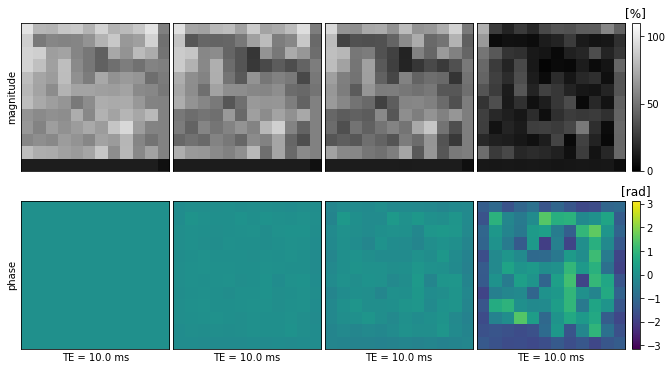

In [20]:
s_ = T.smacro

fig = plt.figure(figsize=(15, 6))

#### first row - magnitude
grid = AxesGrid(fig, 211,
                nrows_ncols=(1, T.te_s.size),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
iz = s_.shape[2] // 2
grid[0].set_ylabel('magnitude')
for i, te in enumerate(T.te_s):
    im = grid[i].imshow(np.abs(s_[:, :, iz, i]*100), vmin=0, vmax=110, cmap='gray')
    grid[i].xaxis.set_ticks([])
    grid[i].yaxis.set_ticks([])
cbar = grid[-1].cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)
cbar.ax.set_title('[%]')
cbar.set_ticks([0, 50, 100])

#### second row - phase
grid = AxesGrid(fig, 212,
                nrows_ncols=(1, T.te_s.size),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
grid[0].set_ylabel('phase')
for i, TE in enumerate(T.te_s):
    im = grid[i].imshow(np.angle(s_[:, :, iz, i]), vmin=-np.pi, vmax=np.pi, cmap='viridis')
    grid[i].set_xlabel('TE = {:.1f} ms'.format(te*1e3))
    grid[i].xaxis.set_ticks([])
    grid[i].yaxis.set_ticks([])
cbar = grid[-1].cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)
cbar.ax.set_title('[rad]')